__Note:__ This is not my solution, solutions for parts 1 and 2 belong to Rounak Banik. I did attempt to solve the predictive modeling portion of the problem, however.  I used this answer to learn from and graduate Springboard on time. Link to his original solution https://github.com/rounakbanik/dsc_springboard/blob/master/challenges/ultimate/ultimate.ipynb

## 1. Exploratory Data Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
logins = pd.read_json('logins.json')

# Convert login team feature to datetime type
logins['login_time'] = pd.to_datetime(logins['login_time'])

# Create a feature for login count
logins['count'] = 1
logins.head()

,login_time,count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [2]:
# Group logins by 15 minute frequency
ts = logins.groupby(pd.Grouper(key='login_time', freq='15min')).count()
ts.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [3]:
# Check for any missing values
sum(ts['count'].isnull())

0

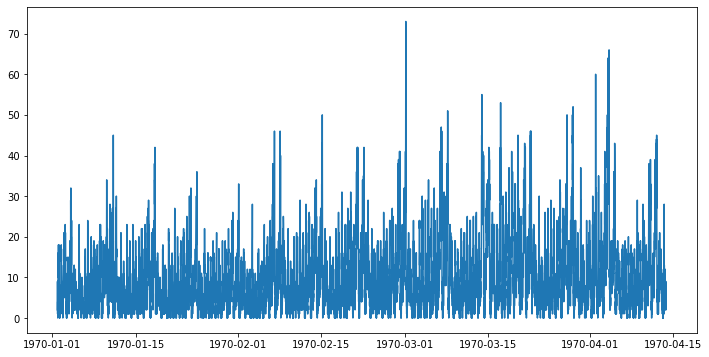

In [4]:
# Plot 15 minute interval login counts
plt.figure(figsize=(12,6))
plt.plot(ts)
plt.show()

In [5]:
# Import calendar library to create lists for days and months
import calendar
days = list(calendar.day_abbr)
months = list(calendar.month_abbr)

# Create features for days, months and time of day
ts['login'] = ts.index
ts['day'] = ts['login'].apply(lambda x: days[x.weekday()])
ts['month'] = ts['login'].apply(lambda x: months[x.month])
ts['time'] = ts['login'].apply(lambda x: x.time())
ts.head()

,count,login,day,month,time
login_time,,,,,
1970-01-01 20:00:00,2,1970-01-01 20:00:00,Thu,Jan,20:00:00
1970-01-01 20:15:00,6,1970-01-01 20:15:00,Thu,Jan,20:15:00
1970-01-01 20:30:00,9,1970-01-01 20:30:00,Thu,Jan,20:30:00
1970-01-01 20:45:00,7,1970-01-01 20:45:00,Thu,Jan,20:45:00
1970-01-01 21:00:00,1,1970-01-01 21:00:00,Thu,Jan,21:00:00


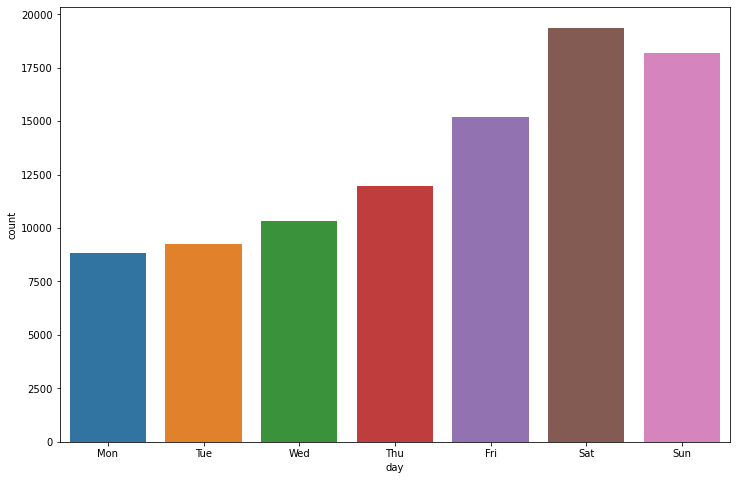

In [6]:
# Plot logins by day
by_day = ts.groupby('day')['count'].sum()
plt.figure(figsize=(12,8))
sns.barplot(x=by_day.index, y=by_day, order=days)
plt.show()

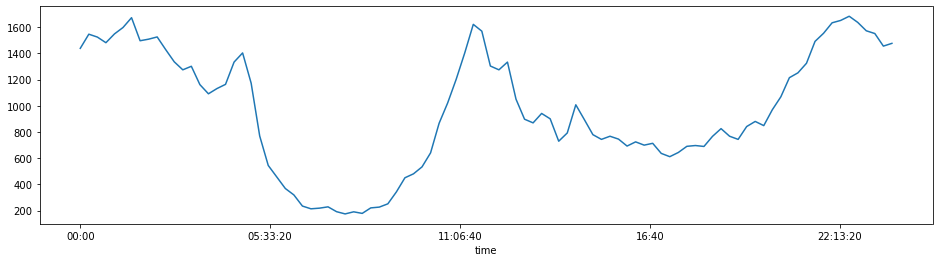

In [21]:
# Plot logins by day
by_day = ts.groupby('time')['count'].sum()
plt.figure(figsize=(16,4))
by_day.plot()
plt.show()

Users were much more active on the weekends and on Friday. During a single day users had the most activity past 10pm to around 2 or 3am. With another peak of activity occuring around noon.

## 2. Experiment and Metrics Design

#### Success Metrics
Note: I'm assuming the demand is equal in both the cities. That is, the demand of cabs in Gotham during the night is the same as the demand of cabs in Metropolis during the day.

We know that the demand in both the cities is complementary in the weekdays; i.e the demand for both cities can be met by the same driver partners as they are at different times. Therefore, if this experiment was indeed sucessful, it would indicate that the drivers, irrespective of which city they belong to, are spending equal amounts of time in Gotham and Metropolis during the weekdays; Metropolis during the day and Gotham during the night.

The success metric I propose is the ratio of passengers taken from Gotham and Metropolis on weekdays. After the introduction of this experiment, if the ratio has regressed towards 1:1, it would mean that the experiment was successful.

#### Experiment
These are the steps I will implement as part of an experiment to deduce if the policy changes have affected the behavior of the drivers.

1. Track the activity of every driver in each city. If the number of Gotham passengers for a particular driver is more, label him/her as a Gotham Driver. Else label as Metropolis Driver.
2. Calculate the proportion of passengers from two cities and divide them into two sample groups: before the experiment and after the experiment.
3. Perform hypothesis testing using the Difference of Proportions test on the two samples. Calculate the Z-Statisitc and the p-value and compare it with an arbritrary significance level, $\alpha$.
4. If the Null Hypothesis holds, it implies that the experiment has been a failure. If the Alternate hypothesis holds, it implies that it has been a success.
5. I will perform the experiment described above and test if the Null Hypothesis can be rejected for both groups. If this is true, then I will suggest that Ultimate Inc continue implementing this policy change. If it cannot be rejected, then I will suggest that they stop and look for other potent options.

## 3. Predictive Modeling

In [7]:
# Load data for ultimate users
ultimate_df = pd.read_json('ultimate_data_challenge.json')
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [8]:
# Check last trip dates to determine date of last data recorded
ultimate_df.last_trip_date.sort_values(ascending=False)

# Set month date and create feature for active users
preceding_date = pd.Timestamp('2014-06-01', tz=None)
ultimate_df['active'] = ultimate_df['last_trip_date'].apply(lambda x: 1 if pd.Timestamp(x, tz=None) >= preceding_date else 0)

# Check proportion of active users to non-active users
ultimate_df.active.value_counts(normalize=True)

0    0.62392
1    0.37608
Name: active, dtype: float64

In [32]:
ultimate_df.active.value_counts()

0    31196
1    18804
Name: active, dtype: int64

Only 37.6% of users were retained.

In [11]:
# Check which features are missing values
ultimate_df.isnull().any()

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
active                    False
dtype: bool

In [18]:
# Fill Nans with mean and mode
ultimate_df['avg_rating_of_driver'] = ultimate_df['avg_rating_of_driver'].fillna(round(ultimate_df['avg_rating_of_driver'].mean(),1))
ultimate_df['phone'] = ultimate_df['phone'].fillna(ultimate_df['phone'].mode()[0])
ultimate_df['avg_rating_by_driver'] = ultimate_df['avg_rating_by_driver'].fillna(round(ultimate_df['avg_rating_of_driver'].mean(),1))

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver      False
avg_surge                 False
last_trip_date            False
phone                     False
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver      False
active                    False
dtype: bool

#### Log Regression feature importance with categorical features scaled with continuous features

In [63]:
# Import models for predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Drop unuseful features
data = ultimate_df.drop(columns=['signup_date', 'last_trip_date','active'])

# Get dummy values for categorical features
data['ultimate_black_user'] = data.ultimate_black_user.replace([True, False], [1,0])

# Split into X and y
X = pd.get_dummies(data)
y = ultimate_df['active']

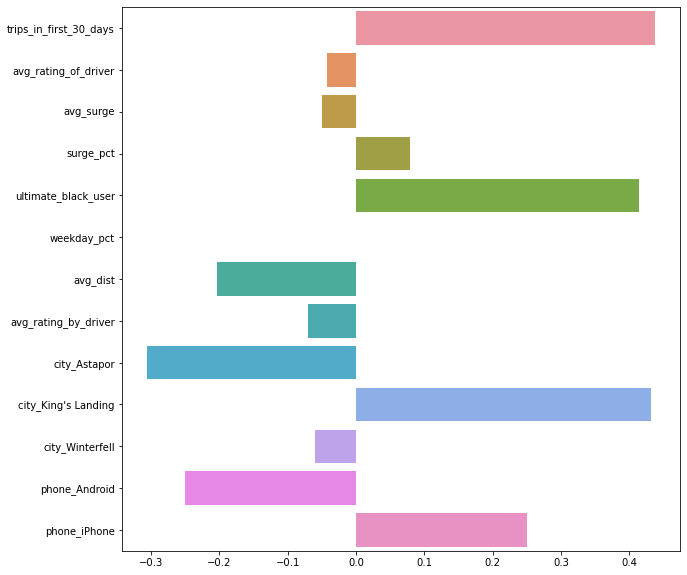

In [64]:
# Scale the features
SS = StandardScaler()
X_scaled = SS.fit_transform(X)

# Train logistic regression model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=40, stratify=y)
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Plot important features
plt.figure(figsize=(10,10))
sns.barplot(y=X.columns, x=lr.coef_[0])

#### Log Regression feature importance with categorical features NOT scaled with continuous features

In [58]:
# Import models for predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Drop unuseful features
data = ultimate_df.drop(columns=['signup_date', 'last_trip_date','active'])

# Get dummy values for categorical features
data['ultimate_black_user'] = data.ultimate_black_user.replace([True, False], [1,0])
data = pd.get_dummies(data)
dummies = data.loc[:,['ultimate_black_user','city_Astapor','city_King\'s Landing','city_Winterfell','phone_Android','phone_iPhone']]

# Scale continuous features
to_scale = data.drop(columns=['ultimate_black_user','city_Astapor','city_King\'s Landing','city_Winterfell','phone_Android','phone_iPhone'])
SS = StandardScaler()
scaled = SS.fit_transform(to_scale)

# Concatinate dummies with scaled features
features = pd.concat([pd.DataFrame(scaled, columns=to_scale.columns), dummies], axis=1)
features.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,ultimate_black_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,0.453984,0.174689,0.113506,0.328202,-0.397131,-0.372650,0.499131,1,0,1,0,0,1
1,-0.600689,0.705689,-0.336268,-0.443394,-0.294653,0.431583,0.499131,0,1,0,0,1,0
2,0.190316,-0.533312,-0.336268,-0.443394,1.053741,-0.880771,0.499131,0,1,0,0,0,1
3,1.772325,-0.002312,0.293416,0.558679,0.514383,-0.602181,0.274861,1,0,1,0,0,1
4,3.090665,-0.356312,0.518303,0.147829,0.579106,-0.467266,0.274861,0,0,0,1,1,0


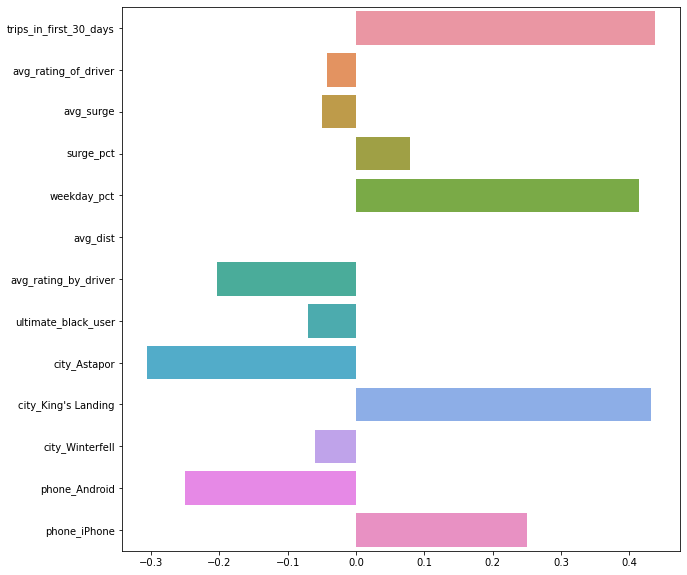

In [60]:
# Split into X and y
X = features
y = ultimate_df['active']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=40, stratify=y)

# Train logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Plot important features
plt.figure(figsize=(10,10))
sns.barplot(y=X.columns, x=lr.coef_[0])

The best predictors of retention are:
- Early use of the service once discovered
- The city of King's Landing
- iPhones

I suggest focusing less in Astapor and increasing operations in King's Landing. Keep users engaged with promotions and perks to increase the chances of taking more trips in the first 30 days. As well as working out a promotional deal with the apple app store.